In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import pywt
import pywt.data
import pandas as pd

YLIM_DEFAULT_OFFSET = 10

def clear_plots():
    plt.clf()
    plt.close()

def plot_coeffs(data, w, title, level, use_dwt=True):
    clear_plots()
    """Show dwt or swt coefficients for given data and wavelet."""
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []

    if use_dwt:
        for i in range(5):
            (a, d) = pywt.dwt(a, w, mode)
            if len(a) > 1:
                ca.append(a)
                cd.append(d)
    else:
        coeffs = pywt.swt(data, w, level)  # [(cAn, cDn), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure(figsize=(20, 12))
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title, fontsize=14)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r')
        if i == 0:
            ax.set_title("Approximation coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g')
        if i == 0:
            ax.set_title("Detail coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals) if len(vals) > 0 else -YLIM_DEFAULT_OFFSET), max(0, 2 * max(vals)) if len(vals) > 0 else YLIM_DEFAULT_OFFSET)
            
def plot_family_of_wavelets(plot_data=[('db', (4, 3)), ('sym', (4, 3)), ('coif', (3, 2))], second_plot_data=[]):
    clear_plots()
    for family, (rows, cols) in plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
        colors = itertools.cycle('bgrcmyk')

        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, x = wavelet.wavefun(level=5)

                color = next(colors)
                ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

    for family, (rows, cols) in second_plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)

        colors = itertools.cycle('bgrcmyk')
        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
                row *= 2

                color = next(colors)
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

                row += 1
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi_r")
                ax.plot(x, phi_r, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi_r")
                ax.plot(x, psi_r, color)
                ax.set_xlim(min(x), max(x))

    plt.show()
    
def plot_signal_decomp(data, w, title):
    clear_plots()
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Approximation Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Detail Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        
    plt.show()

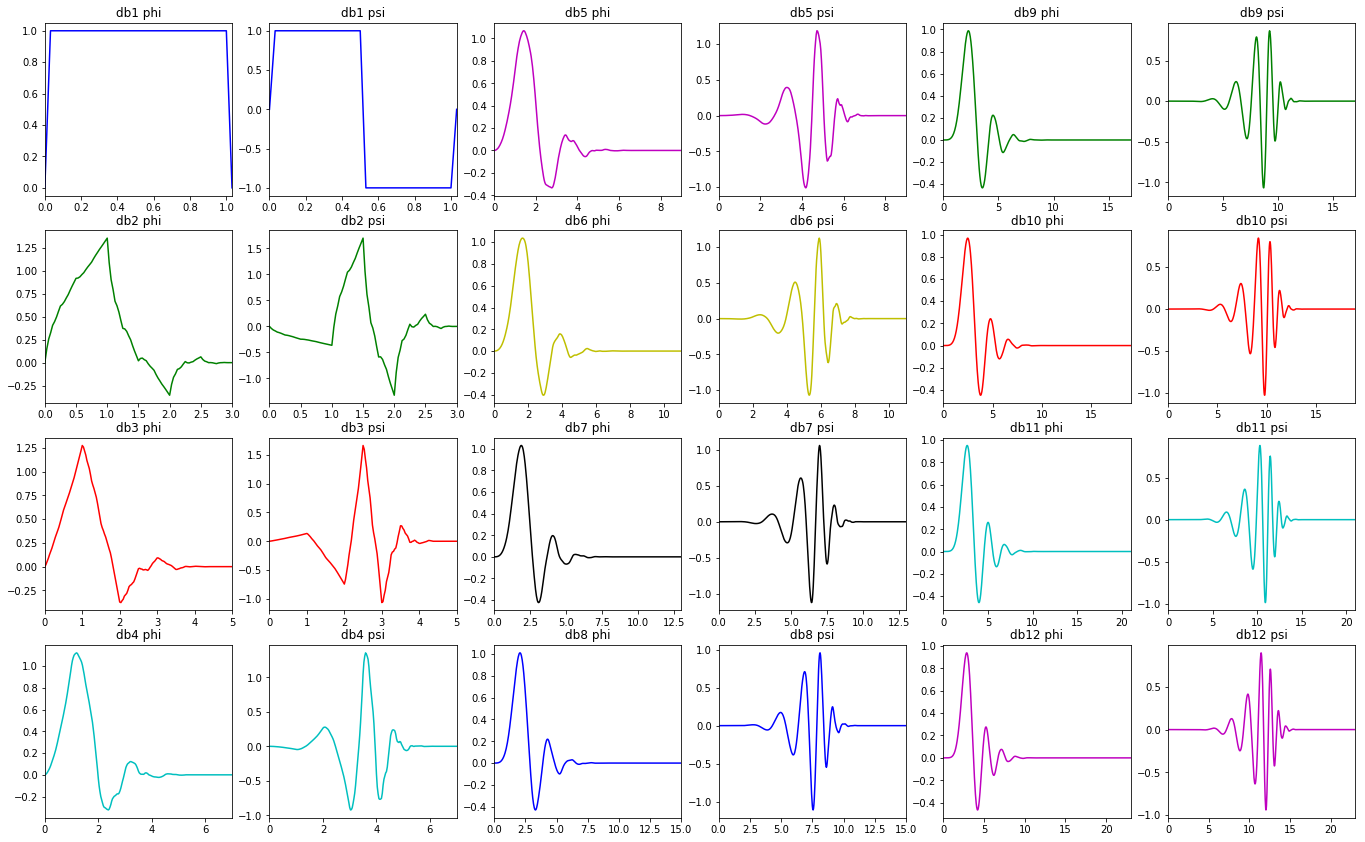

In [2]:
''' 
Exercício 1 
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''

plot_data = [('db', (4, 3))]
# second_plot_data = [('bior', (4, 3)), ('rbio', (4, 3))]

plot_family_of_wavelets(plot_data=plot_data)

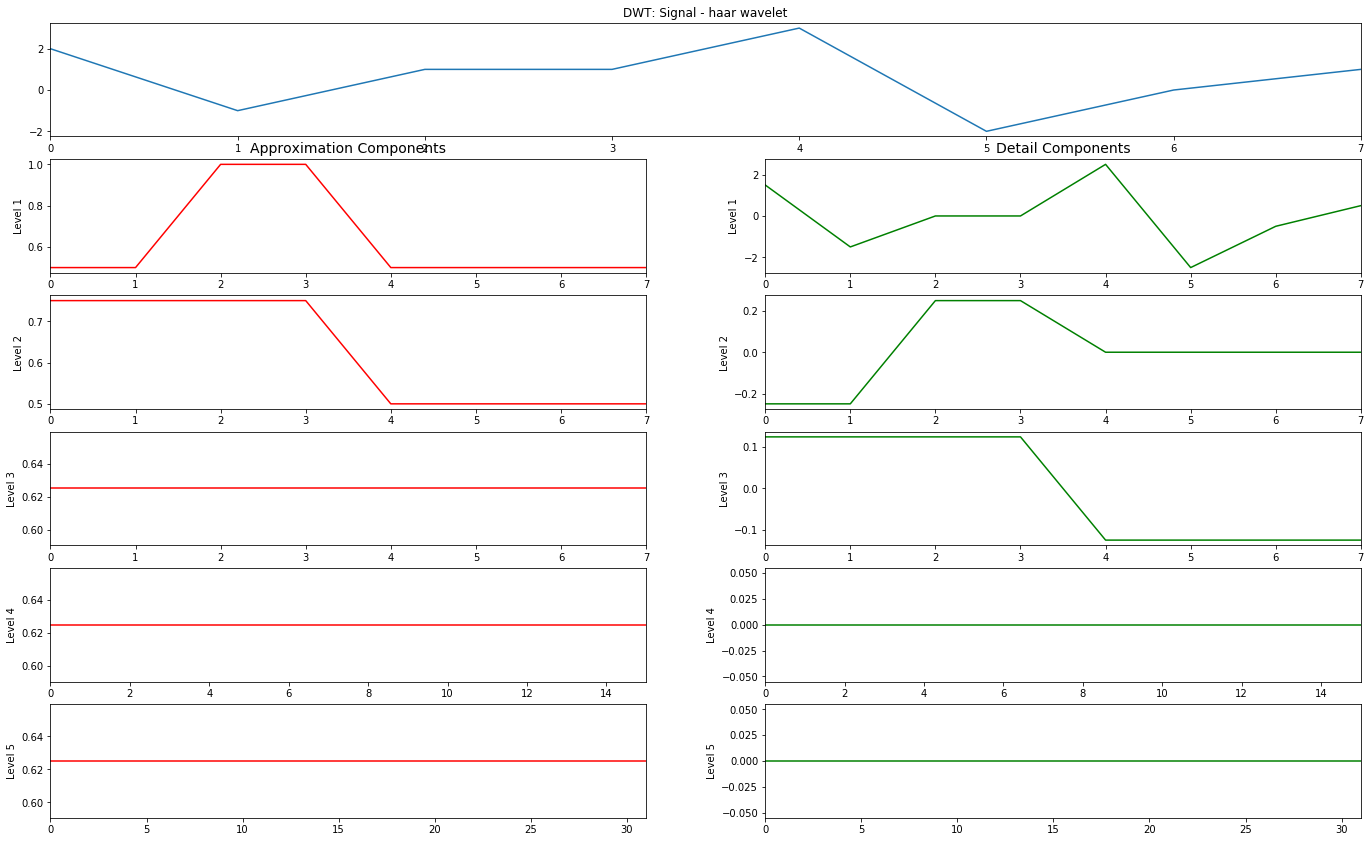

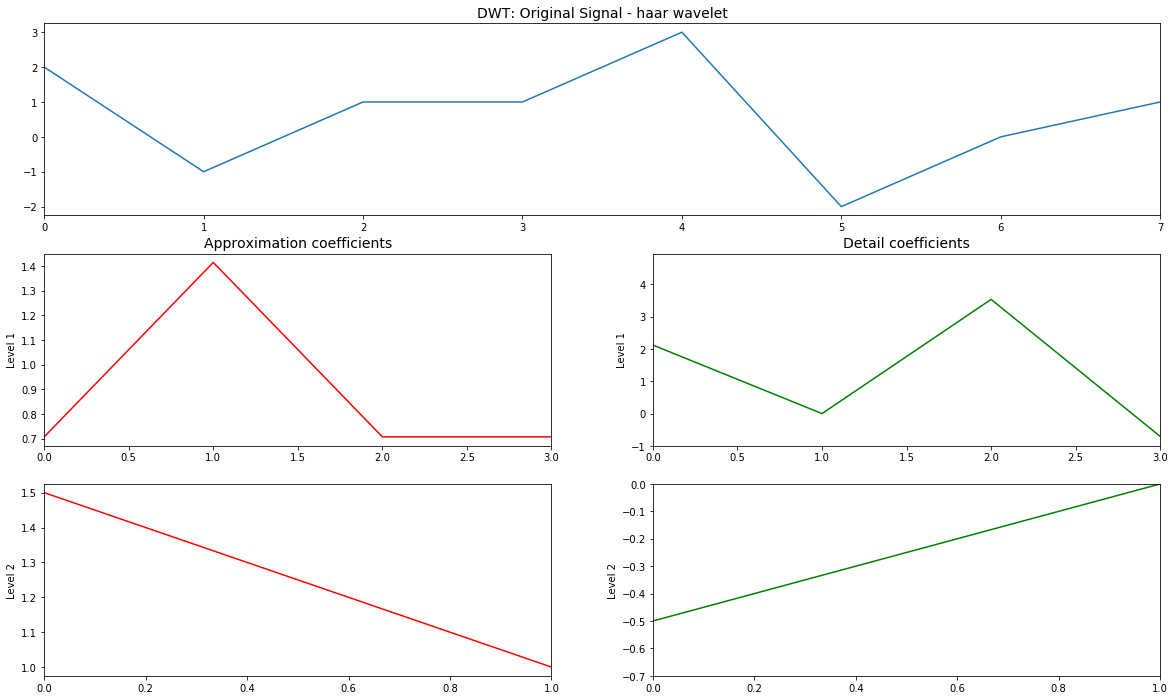

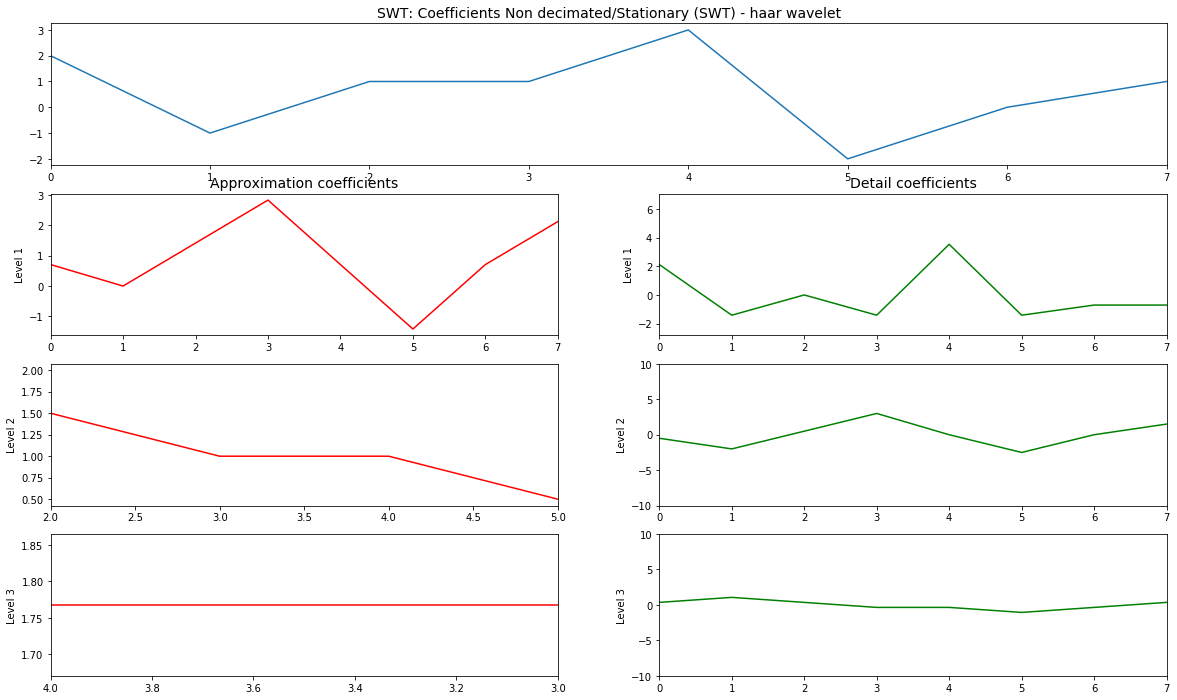

In [3]:
'''
Exercício 3
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''

clear_plots()

wavelet_name = 'haar'
mode = pywt.Modes.sp1DWT = 1

data = [2,-1,1,1,3,-2,0,1]

# plot decomposition
plot_signal_decomp(data, wavelet_name, f"DWT: Signal - {wavelet_name} wavelet")
plt.show()

# Show DWT coefficients
use_dwt = True
plot_coeffs(data, wavelet_name,
            f"DWT: Original Signal - {wavelet_name} wavelet",
            2,
            use_dwt)
plt.show()


'''
Exercício 8
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''
# Show SWT coefficients = Non decimated
use_dwt = False
plot_coeffs(data, wavelet_name, f"SWT: Coefficients Non decimated/Stationary (SWT) - {wavelet_name} wavelet",
            3,
            use_dwt)

plt.show()

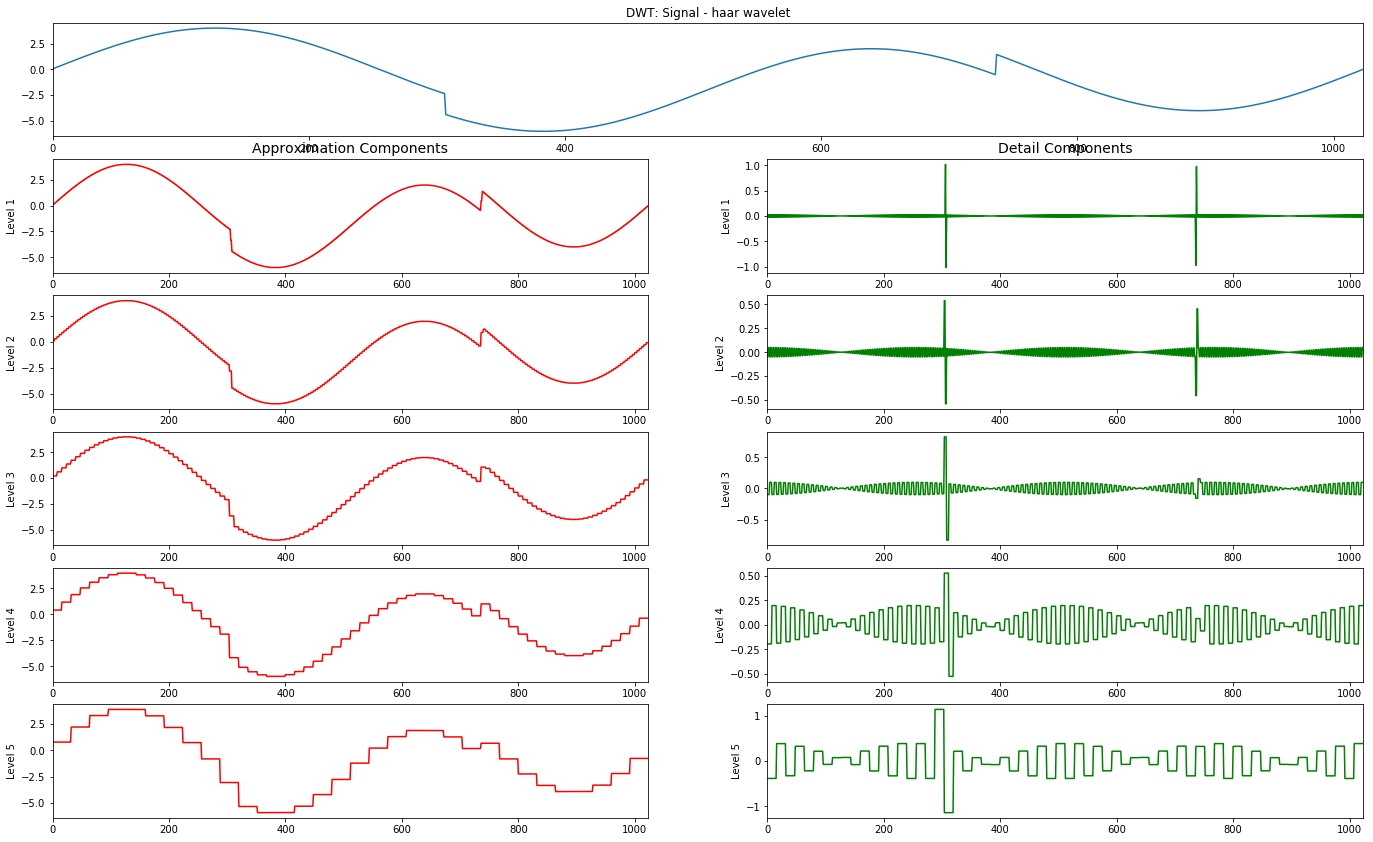

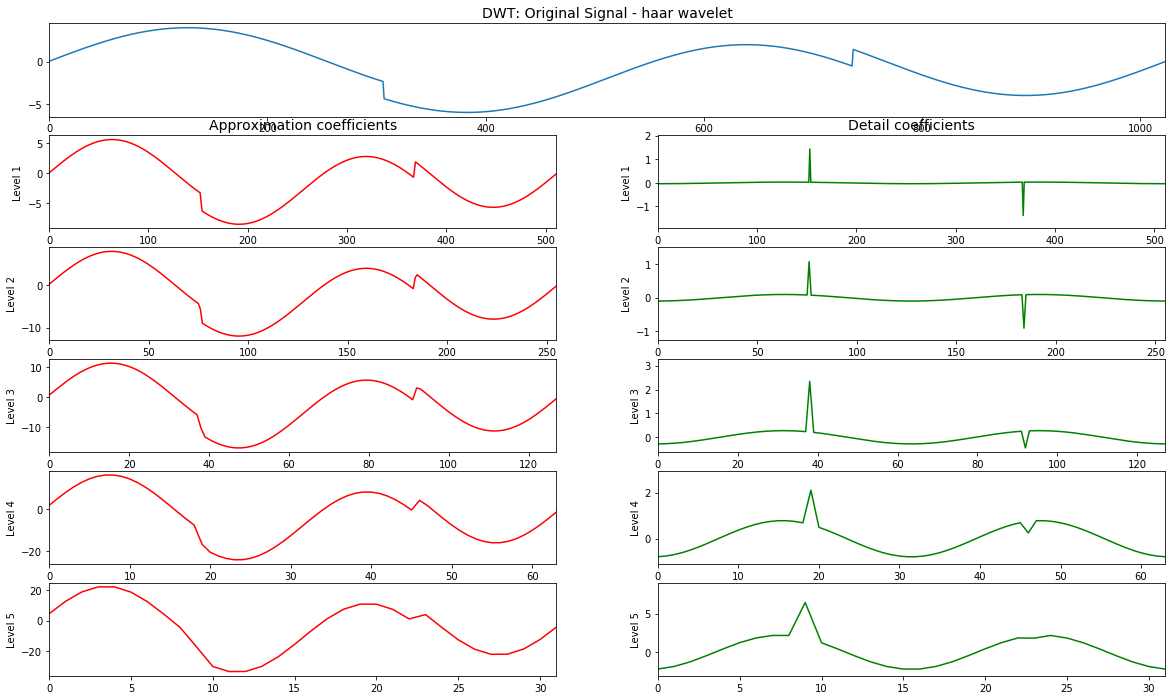

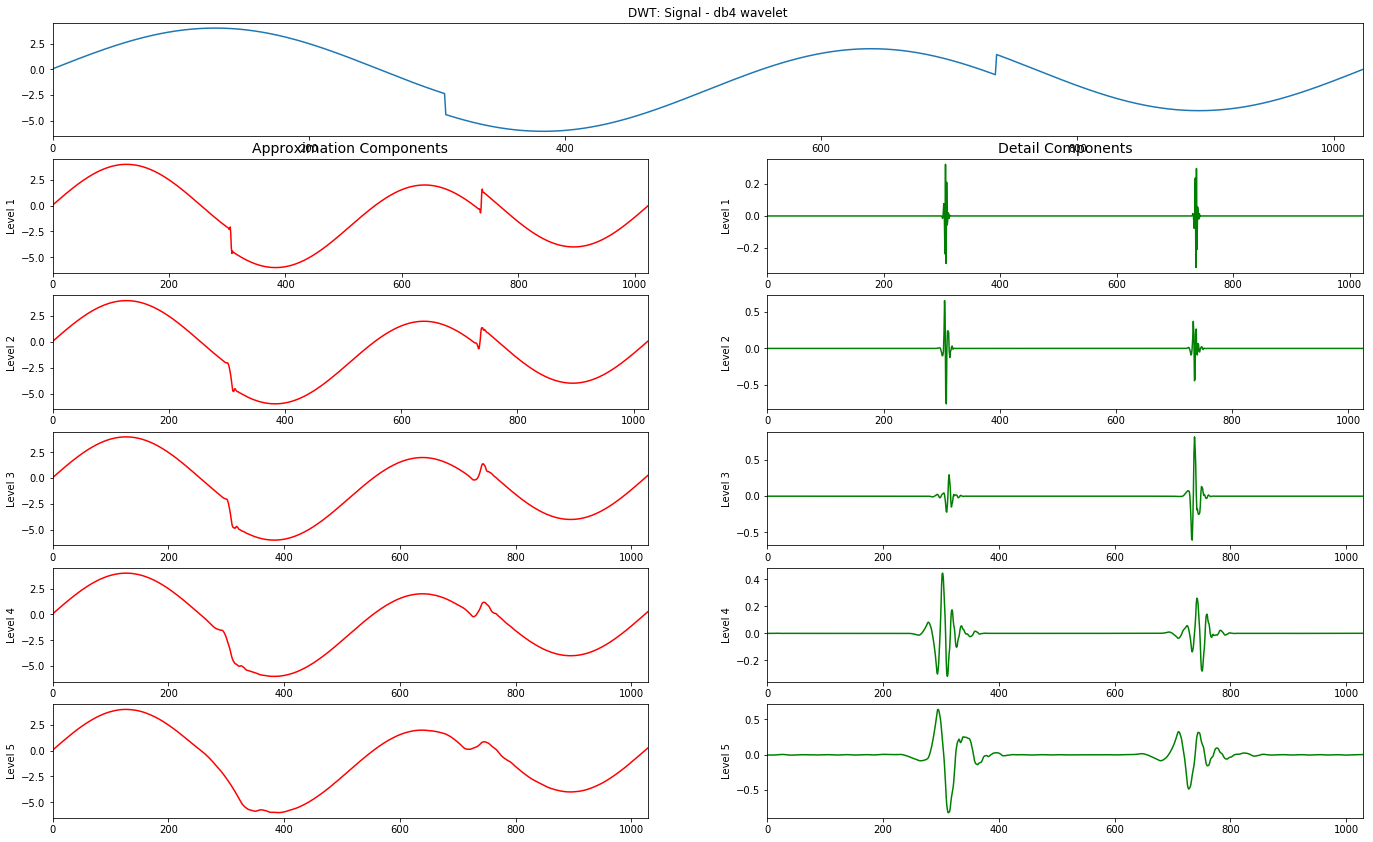

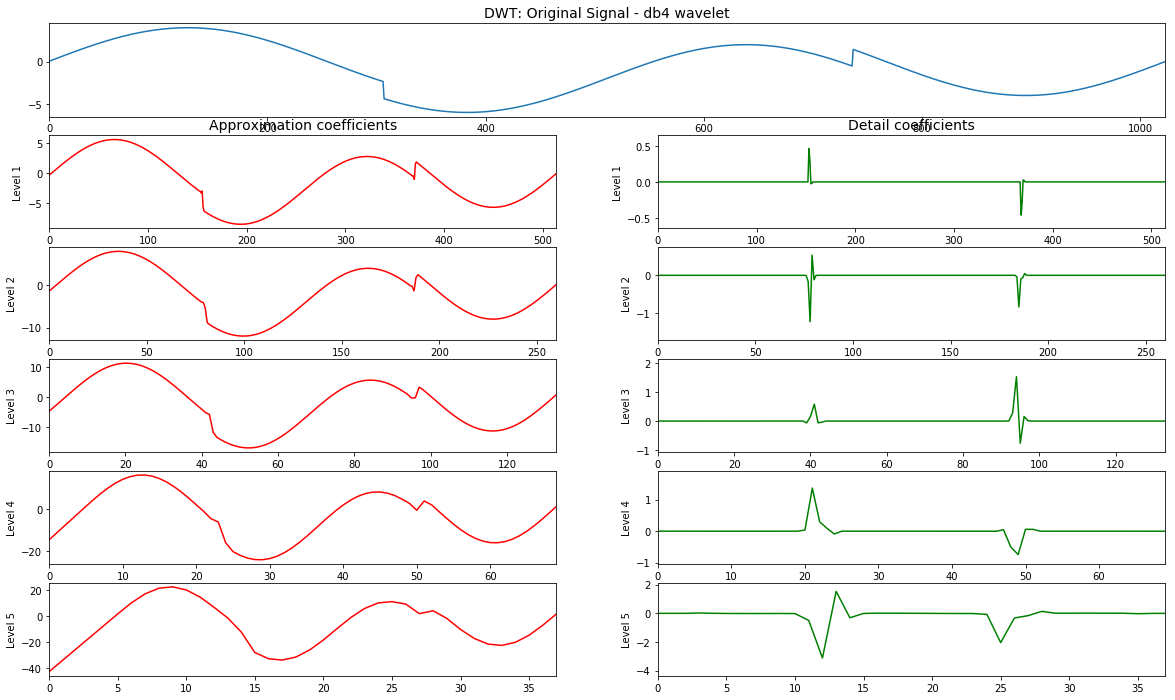

In [4]:
'''
Exercício 4 
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''

heavisine = pywt.data.demo_signal(name='HeaviSine', n=1024)

data = heavisine

### Using haar wavelet
wavelet_name = 'haar'
mode = pywt.Modes.smooth

# plot decomposition
plot_signal_decomp(data, wavelet_name, f"DWT: Signal - {wavelet_name} wavelet")
plt.show()

# Show DWT coefficients
use_dwt = True
plot_coeffs(data, wavelet_name,
            f"DWT: Original Signal - {wavelet_name} wavelet",
            2,
            use_dwt)
plt.show()

### Using db4 wavelet
wavelet_name = 'db4'
mode = pywt.Modes.smooth

# plot decomposition
plot_signal_decomp(data, wavelet_name, f"DWT: Signal - {wavelet_name} wavelet")
plt.show()

# Show DWT coefficients
plot_coeffs(data, wavelet_name,
            f"DWT: Original Signal - {wavelet_name} wavelet",
            2,
            use_dwt)
plt.show()

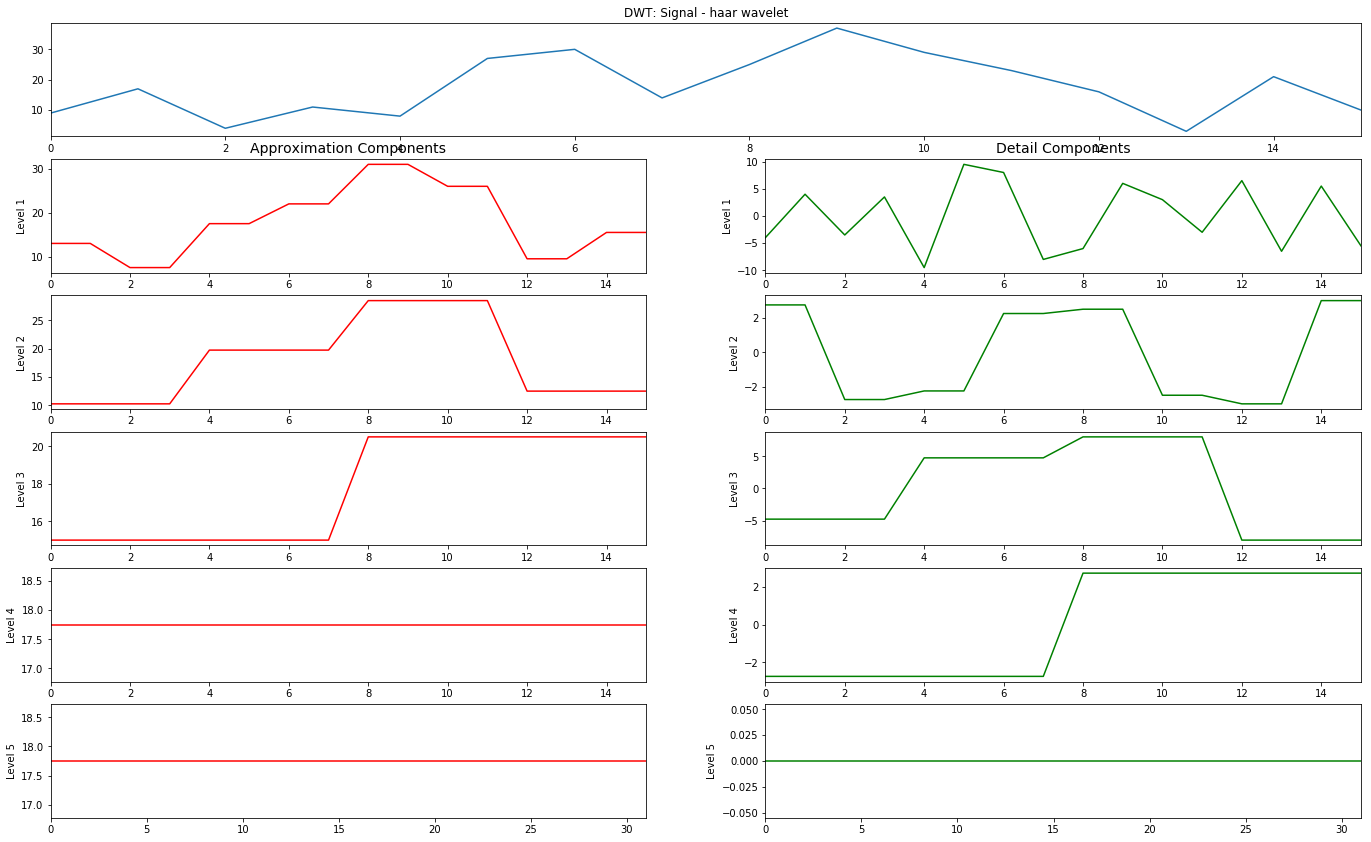

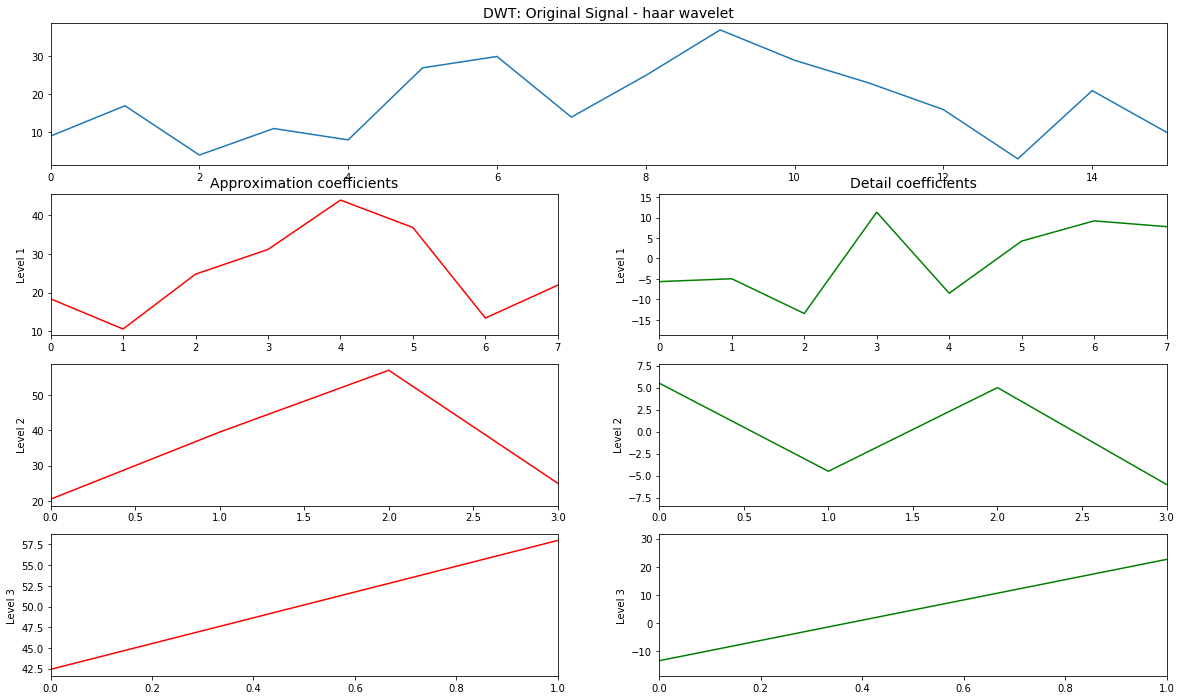

In [5]:
'''
Exercício 5
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''

list_of_size_16 = random.sample(range(1, 40), 16)

data = list_of_size_16

### Using haar wavelet
wavelet_name = 'haar'
mode = pywt.Modes.smooth

# plot decomposition
plot_signal_decomp(data, wavelet_name, f"DWT: Signal - {wavelet_name} wavelet")
plt.show()

# Show DWT coefficients
use_dwt = True
plot_coeffs(data, wavelet_name,
            f"DWT: Original Signal - {wavelet_name} wavelet",
            2,
            use_dwt)
plt.show()

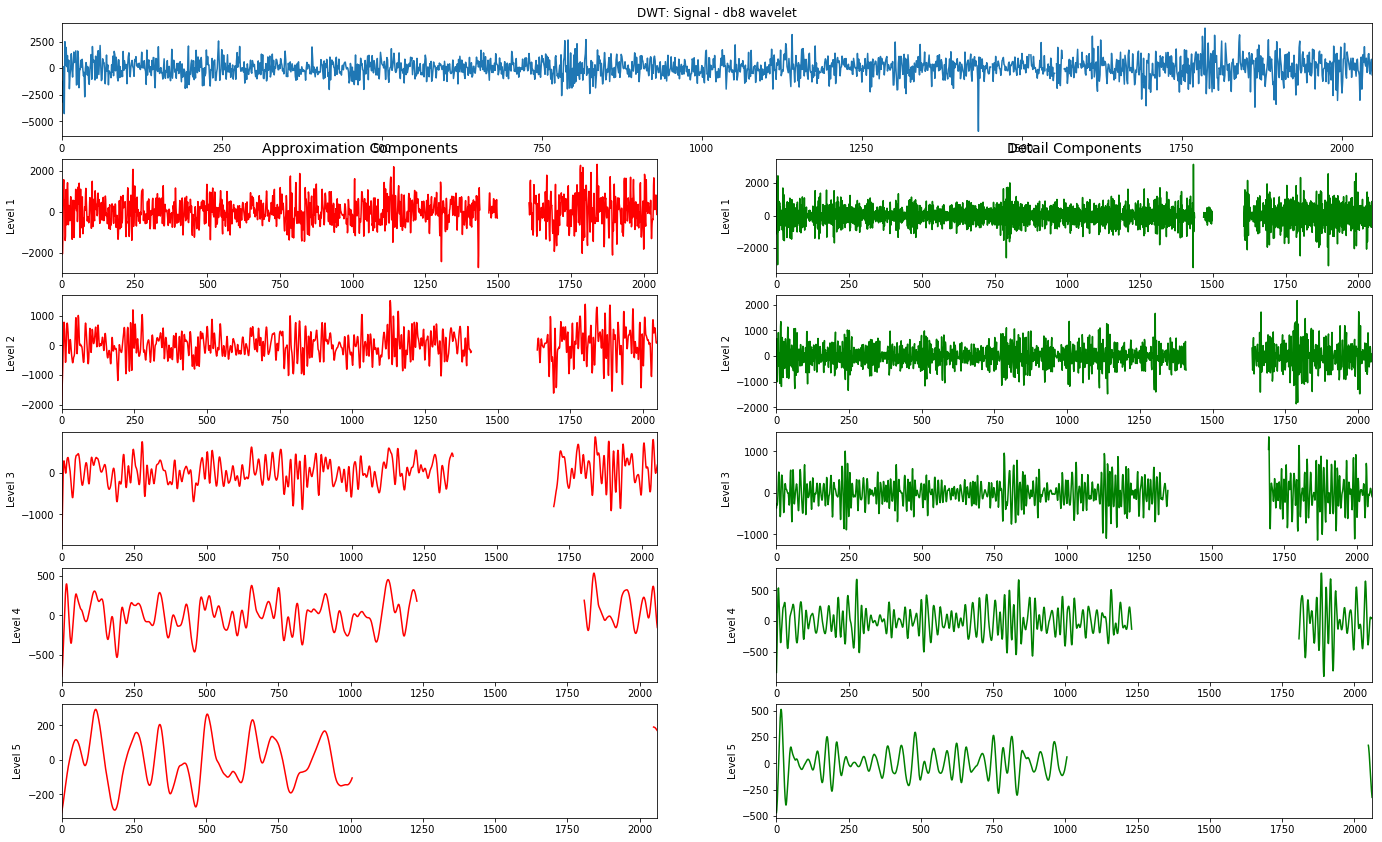

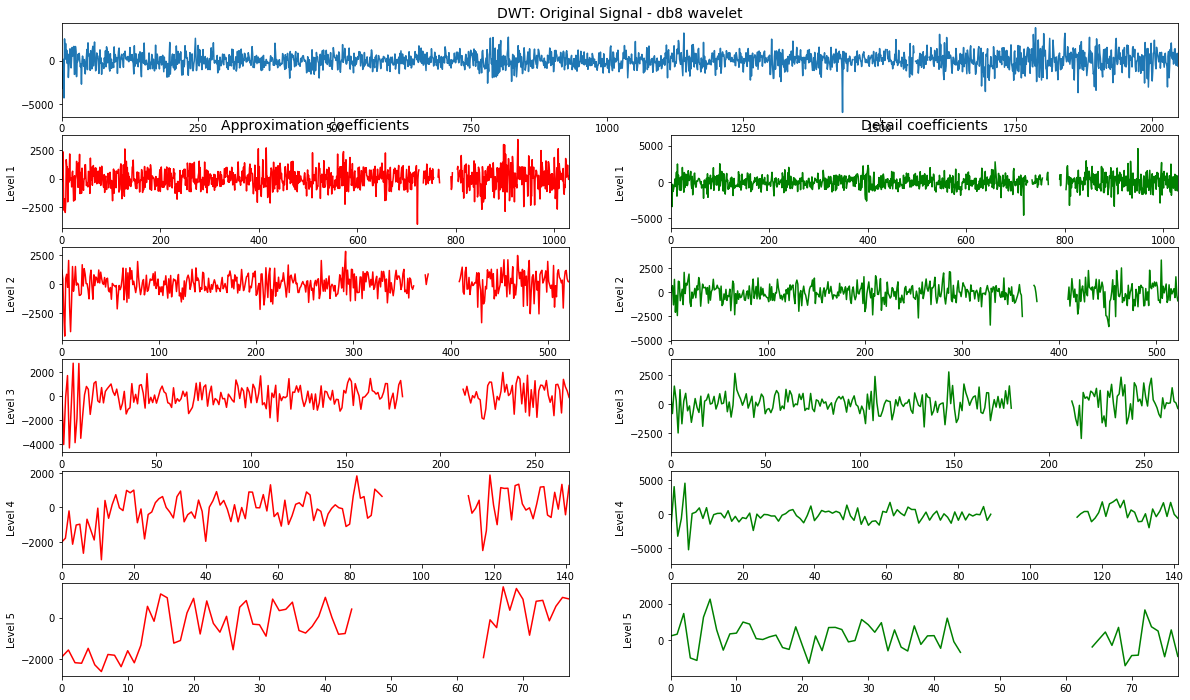

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0


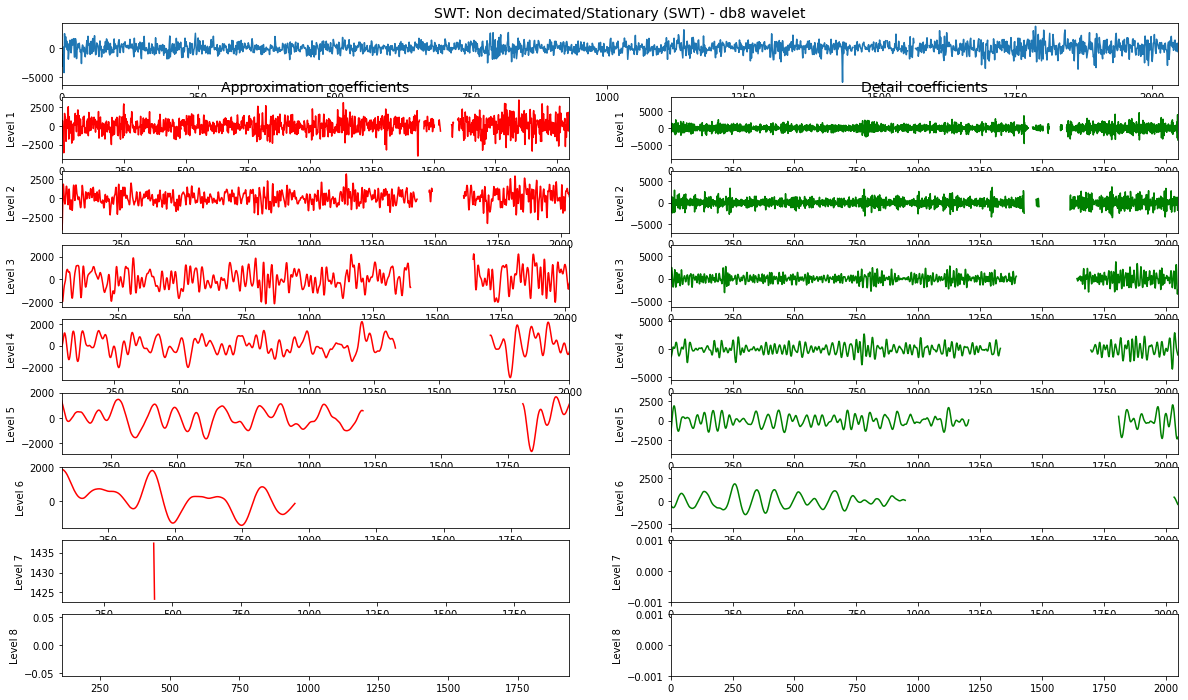

In [6]:
'''
Exercício 10
Lista 4
Professora: Chang
Aluno: Renan de Luca Avila
'''
import pandas as pd

df = pd.read_csv('./data/^BVSP.csv')

length_of_most_recent_data = 2048
data = np.asarray(df['Adj Close'])

data = np.diff(data)[-length_of_most_recent_data:] # calc series of return

clear_plots()

wavelet_name = 'db8'
mode = pywt.Modes.sp1DWT = 1

# plot decomposition
plot_signal_decomp(data, wavelet_name, f"DWT: Signal - {wavelet_name} wavelet")
plt.show()

# Show DWT coefficients
use_dwt = True
plot_coeffs(data, wavelet_name,
            f"DWT: Original Signal - {wavelet_name} wavelet",
            8,
            use_dwt)
plt.show()

# Show SWT coefficients = Non decimated
use_dwt = False
plot_coeffs(data, wavelet_name, f"SWT: Non decimated/Stationary (SWT) - {wavelet_name} wavelet",
            8,
            use_dwt)

plt.show()